Import packages

In [17]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

b2.defaultclock.dt = 0.01*b2.ms

Definitions

In [19]:
min_spike_time = 1 # ms
max_spike_time = 10 # ms   
train_period = 20 * b2.ms  
learning_rate = 0.6

nn = 1
ni = 2

shift learning rule

On PRE :

$shift_{correction} += \Delta shift_{correction}$, 

where

$\Delta shift_{correction} = LearningRate * (tpre_{goal} - tpre_{current})$, 

$tpre_{goal} = MaxSpikeTime + tpre_{first}$,

$tpre_{current} = tpre + (shift + shift_{correction})$

On POST :

$shift = shift + shift_{correction}$,
    
$shift_{correction} = 0\ ms$.


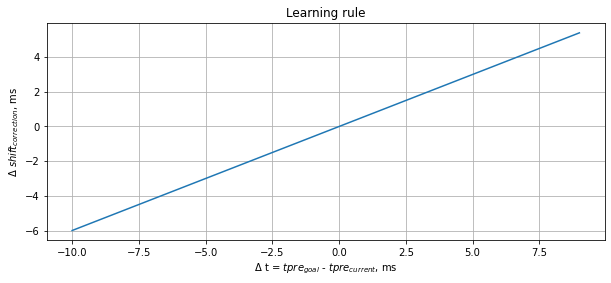

In [20]:
%matplotlib inline 

def show_learning_rule(learning_rate):
    x = np.arange(-10, 10)
    y = learning_rate * x
    plt.figure(figsize = (10, 4))
    plt.plot(x, y)
    plt.grid()
    plt.xlabel("$\Delta$ t = $tpre_{goal}$ - $tpre_{current}$, ms")
    plt.ylabel("$\Delta\ shift_{correction}$, ms")
    plt.title("Learning rule")

show_learning_rule(learning_rate)

Model with shift learning rule

In [21]:
class SNN:
    def __init__(self, nn, ni, train_mode, initial_shifts): 

        # Input_group neurons
        times = [0]*ni * b2.ms
        self.input_group = b2.SpikeGeneratorGroup(ni, list(range(ni)), times, name = "input_group")

        # Main neurons
        model_n = '''
          dv/dt = (v_rest_n - v + g_n * (E_exc_n - v)) / tau_n: volt
          tau_n : second
          vt_n : volt
          v_rest_n : volt
          v_reset_n : volt
          E_exc_n : volt
          g_n : 1
          train_mode_n : 1
          tpre_first : second
          '''
        self.group_n = b2.NeuronGroup(nn, model=model_n, threshold='v>vt_n', reset='v=v_reset_n', 
          refractory=max_spike_time*b2.ms, method='euler', events = {"suppress_event" : "v < v_reset_n"})
        self.group_n.train_mode_n = train_mode
        self.group_n.tau_n = 0.7 * b2.ms     
        self.group_n.vt_n = -52 * b2.mV
        self.group_n.v_rest_n = -65 * b2.mV
        self.group_n.v_reset_n = self.group_n.v_rest_n
        self.group_n.v = self.group_n.v_rest_n
        self.group_n.g_n = 0
        self.group_n.E_exc_n = 0 * b2.mV

        # EXCISITORY synapses 
        model_e = '''
          g = g_amp * exp((tpre + shift + shift_correction - t) / tau_s) * int((t > tpre + shift + shift_correction) and (tpre >= 0 * ms)) : 1
          g_n_post = g : 1 (summed)
          shift : second
          shift_correction : second
          tau_s : second
          g_amp : 1
          tpre : second
          train_mode_e : 1
          k : 1
          ''' 
        on_pre_e = '''
          tpre = t
          tpre_first = int((tpre_first < 0 * ms) or (t - tpre_first > max_spike_time * ms)) * t + int((tpre_first >= 0 * ms) and (t - tpre_first <= max_spike_time * ms)) * tpre_first
          shift_correction += train_mode_e * k * ((max_spike_time * ms + tpre_first) - (t + shift + shift_correction))
          '''
        on_post_e = { 
          "post" : '''
            shift += shift_correction
            shift_correction = 0 * ms
            k = k * 0.8
            ''',
          "suppress" : 
            "shift_correction = 0 * ms" }
        
        self.synapses_e = b2.Synapses(self.input_group, self.group_n, model=model_e, on_pre=on_pre_e, 
          on_post=on_post_e, method='euler', on_event={"suppress" : "suppress_event"})
        self.synapses_e.connect()
        self.synapses_e.train_mode_e = train_mode
        self.synapses_e.k = 0.4     # learning rate 0..1
        self.synapses_e.tpre = -1 * b2.ms 
        self.synapses_e.tpre_first = -1 * b2.ms 
        self.synapses_e.tau_s = 0.3 * b2.ms
        self.synapses_e.g_amp = 0.6 # before was 0.2 (the value is increased to make the main neuron fire from the begining of simulation)
        self.synapses_e.shift = initial_shifts


        self.net = b2.Network(self.input_group, self.group_n, self.synapses_e)
        

Training function

In [22]:
def show_plots(e_state_mon, s_state_mon, i_spike_mon, e_spike_mon, ind_input):

    # plot the evolution of shifts
    plt.figure(figsize = (12, 4))
    NS = min(len(ind_input), 4) 
        #plt.plot(s_state_mon.t/b2.ms, (s_state_mon.shift[ind_input[s] * nn + n]) / b2.ms , label='$shift$', linestyle = '-.')
    plt.plot(s_state_mon.t/b2.ms, (s_state_mon.shift[ind_input[0]] + s_state_mon.shift_correction[ind_input[0]]) / b2.ms, linestyle = '-.', label='delay on the 1st synapse')
    plt.plot(s_state_mon.t/b2.ms, (s_state_mon.shift[ind_input[1]] + s_state_mon.shift_correction[ind_input[1]]) / b2.ms, linestyle = '-', label='delay on the 2nd synapse')
    for t in i_spike_mon.spike_trains()[ind_input[0]]:
        plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
    for t in i_spike_mon.spike_trains()[ind_input[1]]:
        plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
    for t in e_spike_mon.spike_trains()[0]:
        plt.axvline(t/b2.ms, ls='--', c='C2', lw=1.5) # green == main
    plt.legend()
    plt.grid()
    plt.xlabel("$t$, ms")
    plt.ylabel("$delay$, ms")
    # plt.figure(figsize = (12, 10))
    # NS = min(len(ind_input), 4) 
    # for n in range(nn):
    #     for s in range(NS):
    #         sp_cell = NS * 100 + nn * 10 + s * nn + n + 1 # subplot coordinate
    #         if (n==0 and s==0): sp0 = plt.subplot(sp_cell) # make equal scales
    #         else: plt.subplot(sp_cell, sharex=sp0, sharey=sp0)
    #         plt.plot(s_state_mon.t/b2.ms, (s_state_mon.shift[ind_input[s] * nn + n]) / b2.ms , label='$shift$', linestyle = '-.')
    #         plt.plot(s_state_mon.t/b2.ms, (s_state_mon.shift[ind_input[s] * nn + n] + s_state_mon.shift_correction[ind_input[s] * nn + n]) / b2.ms , label='$shift + shift_{correction}$')
    #         for t in i_spike_mon.spike_trains()[ind_input[s]]:
    #             plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
    #         for t in e_spike_mon.spike_trains()[n]:
    #             plt.axvline(t/b2.ms, ls='--', c='C2', lw=1.5) # green == main
    #         plt.legend()
    #         plt.grid()
    #         plt.xlabel("t, ms")
    #         plt.ylabel("ms")
            # plt.title(f"shift changing from {s} input neuron")

    # plot the evolution of membrane potential 
    plt.figure(figsize = (12, 4))
    for n in range(nn):
        if (n==0): sp1 = plt.subplot(nn*100 + 10*1 + n + 1) # make equal scales
        else: plt.subplot(nn*100 + 10*1 + n + 1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.v[n]/b2.mV, label='$v$')
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.vt_n[n]/b2.mV , label='$v_T$', linestyle = '-.')
        #plt.plot(e_state_mon.t/b2.ms, e_state_mon.g_n[n] , label='g_n')
        for t in i_spike_mon.spike_trains()[ind_input[0]]:
            plt.axvline(t/b2.ms + max_spike_time, ls='--', c='C1', lw=1) # orange == input
        # for t in i_spike_mon.t:
        #     plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
        for t in e_spike_mon.spike_trains()[n]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1.5) # green == main
        plt.legend()
        plt.grid()
        plt.xlabel("$t$, ms")
        plt.ylabel("$v$, mV")
        #plt.title("Voltage changing")



def training_the_model(init_shift, input_spike_time):

    shifts = np.array([init_shift]) * b2.ms 
    snn = SNN(nn, ni, 1, shifts)

    e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
    s_state_mon = b2.StateMonitor(snn.synapses_e, ['shift', 'shift_correction'], record=True)
    i_spike_mon = b2.SpikeMonitor(snn.input_group)
    e_spike_mon = b2.SpikeMonitor(snn.group_n)
    snn.net.add(e_state_mon)
    snn.net.add(s_state_mon)
    snn.net.add(i_spike_mon)
    snn.net.add(e_spike_mon)

    num = 1
    train_spike_time = input_spike_time # spikes in equal times
    for _ in range(num):
        snn.input_group.set_spikes(list(range(ni)), train_spike_time * b2.ms, train_period)
        snn.net.run(140 * b2.ms)
        
        snn.input_group.set_spikes(list(range(ni)), [30000]*ni * b2.ms, 0 * b2.ms)
        snn.net.run(10 * b2.ms)

    # init_shifts = (shifts/b2.ms*10//1).reshape(ni, nn).transpose()
    print("Initial shift:")
    print(*shifts/b2.ms)
    # final_shifts = (snn.synapses_e.shift/b2.ms*10//1).reshape(ni, nn).transpose()
    print("Final shift:")
    print(np.round(snn.synapses_e.shift/b2.ms, 2))
    print("\n")

    ind_input_to_show = [0, 1]
    show_plots(e_state_mon, s_state_mon, i_spike_mon, e_spike_mon, ind_input_to_show)

    snn.net.remove(e_state_mon)
    snn.net.remove(s_state_mon)
    snn.net.remove(i_spike_mon)
    snn.net.remove(e_spike_mon)

        

Training the model

1st EXPERIMENT

initial $tpre_{current}$ from second neuron is below than $tpre_{goal}$  $=>$  $shift$ from second neuron will INCREASE until it will be near $tpre_{goal}$ value 


// initial $tpre_{current} = input\ spike\ time +  init\ shift = 3 + 4 = 7$

// $tpre_{goal} = tpre_{first} + MaxSpikeTime = 0.1 + 10 = 10.1$

Initial shift:
[1. 4.]
Final shift:
[9.65 7.84]




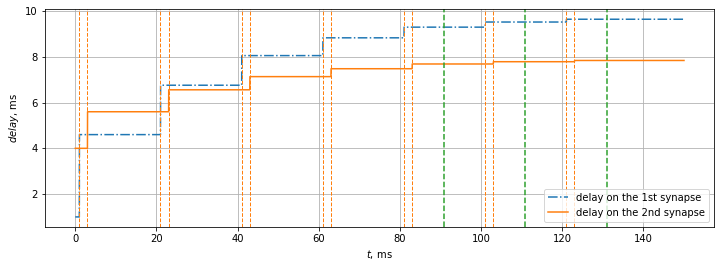

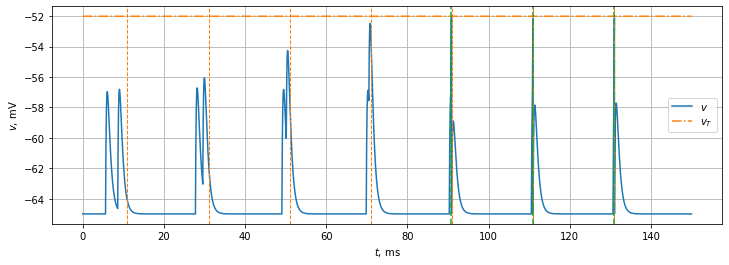

In [23]:
input_spike_time = [1, 3]
init_shift = [1, 4]
training_the_model(init_shift, input_spike_time)


2nd EXPERIMENT

initial $tpre_{current}$ from second neuron is ABOVE $tpre_{goal}$  $=>$  $shift$ from second neuron will DECREASE until it will be near $tpre_{goal}$ value 


// initial $tpre_{current} = input\ spike\ time +  init\ shift = 3 + 10 = 13$

// $tpre_{goal} = tpre_{first} + MaxSpikeTime = 0.1 + 10 = 10.1$

Initial shift:
[ 1. 10.]
Final shift:
[9.71 8.06]




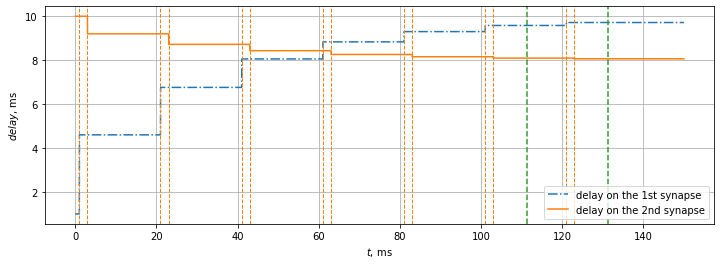

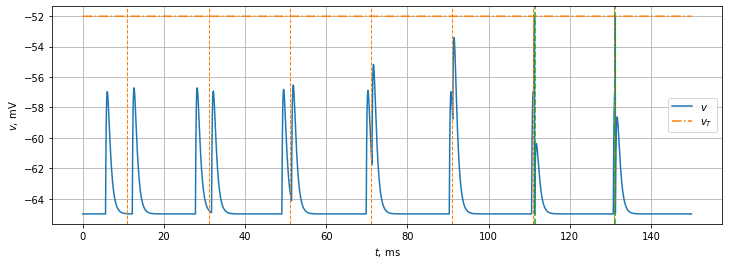

In [24]:
input_spike_time = [1, 3]
init_shift = [1, 10]
training_the_model(init_shift, input_spike_time)
